In [23]:
import torch 
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
import time
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import warnings
from skimage import io, transform
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.ion()
data_dir = "/home/lbenboudiaf/Bureau/ImagesClassification/dataset/GroceryStoreDataset/dataset/subClasses"
model_name = "squeezenet"
num_classes = 43
batch_size = 8
num_epochs = 30 #Valeur Initiale par défaut comme dans le TP du Prof 
feature_extract = True

In [24]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    
    #Tableau "losses" afin de stocker toutes les valeurs calculer.
    losses_train = []
    losses_val = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # récupéré le model et calculer sa fonction loss 
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase, Backward 
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            if phase == 'train': 
                losses_train.append(epoch_loss)
            else:
                losses_val.append(epoch_loss)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, losses_train, losses_val

In [25]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [26]:
#Definition du model Squeezenet.
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0

    if model_name == "squeezenet":
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224
    else:
        print("Invalid model name")
        exit()

    return model_ft, input_size

# Initialisé le model pour ce dataset 
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

In [27]:
import os
# Augmentaion et normalisation de données pour le jeux d'apprentissage.  
# Normalisation des jeux de test et de validation 
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
        transforms.CenterCrop(input_size),
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

def generate_fake_train(data_set):
    #Generate Fake Trainning Dataset 
    for i in range(0, len(data_set['train'].samples)):
        create_sample = {j: datasets.ImageFolder(os.path.join(data_dir, j), data_transforms[j]) for j in ['train', 'val']}
        data_set['train'].samples.append(create_sample['train'].samples[i])
    return data_set

print("Initializing Datasets and Dataloaders...")
# Generation de jeux d'apprentissage et de validation 
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
image_datasets = generate_fake_train(image_datasets)

print(image_datasets['train'].classes)
print(len(image_datasets['train'].samples))
print(len(image_datasets['val'].samples))
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=10) for x in ['train', 'val', 'test']}
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...
['Apple', 'Asparagus', 'Aubergine', 'Avocado', 'Banana', 'Cabbage', 'Carrots', 'Cucumber', 'Garlic', 'Ginger', 'Juice', 'Kiwi', 'Leek', 'Lemon', 'Lime', 'Mango', 'Melon', 'Milk', 'Mushroom', 'Nectarine', 'Oat-Milk', 'Oatghurt', 'Onion', 'Orange', 'Papaya', 'Passion-Fruit', 'Peach', 'Pear', 'Pepper', 'Pineapple', 'Plum', 'Pomegranate', 'Potato', 'Red-Beet', 'Red-Grapefruit', 'Satsumas', 'Sour-Cream', 'Sour-Milk', 'Soy-Milk', 'Soyghurt', 'Tomato', 'Yoghurt', 'Zucchini']
4970
2485


In [28]:
# Envoyer le model au GPU
model_ft = model_ft.to(device)
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observation des paramètres sont optimisé 
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.1.weight
	 classifier.1.bias


In [29]:
import copy 
#fonction de loss
criterion = nn.CrossEntropyLoss()

# Envoyer le jeux de d'apprentissage et de validation, EVALUATION DU Model. 
# Premier essaye avec 15 epoche, déduction le nombre optimale d'époche = 5. 
# Deuxième essaye meilleur resultat
model_ft, hist, loss_train, loss_val = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs, is_inception=(model_name=="inception"))


Epoch 0/29
----------
train Loss: 2.1447 Acc: 0.4525


RuntimeError: Caught RuntimeError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/_utils/collate.py", line 79, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/_utils/collate.py", line 79, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/_utils/collate.py", line 55, in default_collate
    return torch.stack(batch, 0, out=out)
RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 348 and 464 in dimension 2 at /pytorch/aten/src/TH/generic/THTensor.cpp:612


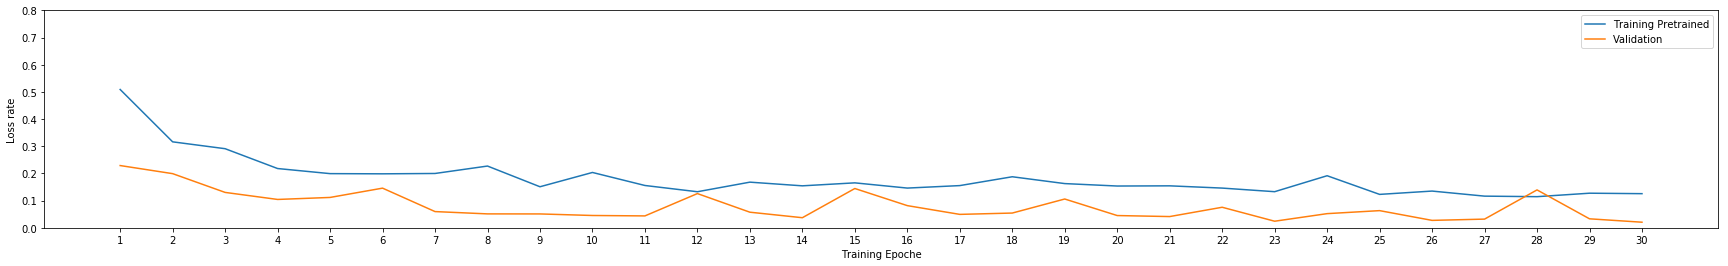

In [21]:
#Create plot of Accuarcy train and validation.

plt.xlabel("Training Epoche")
plt.ylabel("Loss rate")
plt.plot(range(1,num_epochs+1),loss_train,label="Training Pretrained")
plt.plot(range(1,num_epochs+1),loss_val,label="Validation")
plt.ylim((0,0.8))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.rcParams["figure.figsize"] = (30,4)
plt.show()